# Linear Regression: Engineering & Regularizaion
#### King Count Housing Data
* June 14, 2019
* Flatiron School, NYC (mhtn-ds-042219)

## Project Description
## Import libraries and set up environment

In [23]:
import pandas as pd
import numpy as np 

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', 300)

In [136]:
class LinearModeler():
    %matplotlib inline
    
    def __init__(self, data_file=''):
        self.df = None
        self.target = None
        self.features = None
        self.data_file = data_file
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.train_lm = None
        self.y_train_pred = None
        self.train_mae = None
        self.train_mse = None
        self.train_rmse = None
        self.y_pred = None
        self.test_mae = None
        self.test_rmse = None
        self.target_std = None
        
    def read_csv(self, data_file=''):
        if data_file != '':
            self.data_file = data_file
        try:
            self.df = pd.read_csv(self.data_file,index_col='id')
            return self.df.shape
            
        except Exception as e:
            print(e)
            
    def explore_data(self):
        self.df.shape

        #correlation matrix
        corrmat = self.df.corr()
        f, ax = plt.subplots(figsize=(12, 9))
        sns.heatmap(corrmat, vmax=.8, square=True)
        
    def plot_pairs(self, cols):
        sns.pairplot(self.df, vars=cols)
        
    def missing_data(self):
        #missing data
        total = self.df.isnull().sum().sort_values(ascending=False)
        percent = (self.df.isnull().sum()/self.df.isnull().count()).sort_values(ascending=False)
        missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        return missing_data.head(20)
        
    def set_target_and_features(self, target, features):
        self.target = self.df[target]
        self.features = self.df[features]
        
    def evaluate_train_set(self):
        try:
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.features, self.target, random_state=34,test_size=0.2)
        except Exception as e:
            print(e)
            
        print("Training set - Features: ", self.X_train.shape, "Target: ", self.y_train.shape)
        print("Test set - Features: ", self.X_test.shape, "Target: ",self.y_test.shape)
        
        #instantiate a linear regression object
        self.train_lm = linear_model.LinearRegression()

        #fit the linear regression to the data
        self.train_lm = self.train_lm.fit(self.X_train, self.y_train)


        print('\nTRAINING STATS')
        print('Training Intercept: {}'.format(self.train_lm.intercept_))
        print('Training Coefficients:\n{}'.format(self.train_lm.coef_))
        print ("Training R^2 Score:", self.train_lm.score(self.X_train, self.y_train))
        
        self.y_train_pred = self.train_lm.predict(self.X_train)
        self.train_mae = metrics.mean_absolute_error(self.y_train, self.y_train_pred)
        self.train_mse = metrics.mean_squared_error(self.y_train, self.y_train_pred)
        self.train_rmse = np.sqrt(metrics.mean_squared_error(self.y_train, self.y_train_pred))


        print('TRAINING ERRORS')
        print('Mean Absolute Error:', self.train_mae )
        print('Mean Squared Error:',  self.train_mse)
        print('Root Mean Squared Error:' , self.train_rmse)
        
        self.target_std = self.target.std()

        print('Mean Absolute Error:', self.train_mae/self.target_std)
        print('Root Mean Squared Error:' , self.train_rmse/self.target_std)
            

    def predict_test(self):
        self.y_pred = self.train_lm.predict(self.X_test)
        plt.scatter(self.y_test, self.y_pred)
        plt.xlabel("True Values")
        plt.ylabel("Predictions")
        sns.residplot(self.y_pred, self.y_test, lowess=True, color="g")
        
        print ("Test R^2 Score:", self.train_lm.score(self.X_test, self.y_test))
        
        self.test_mae = metrics.mean_absolute_error(self.y_test, self.y_pred)
        self.test_rmse = np.sqrt(metrics.mean_squared_error(self.y_test, self.y_pred))


        print('Mean Absolute Error:' + str(metrics.mean_absolute_error(self.y_test, self.y_pred)))
        print('Mean Squared Error:' + str(metrics.mean_squared_error(self.y_test, self.y_pred)))
        print('Root Mean Squared Error:' + str(np.sqrt(metrics.mean_squared_error(self.y_test, self.y_pred))))
        
        print('Mean Absolute Error  Z:', self.test_mae/self.target_std )
        print('Root Mean Squared Error Z:' , self.test_rmse/self.target_std)
        
        print('Training: ', self.train_rmse, "vs. Testing: ", self.test_rmse)
        
        
            

## Load Data

In [137]:
data_file = 'kc_housing_data_for_feat_engineering_lab.csv'

KC = LinearModeler()
KC.read_csv(data_file)

(21600, 24)

## Explore Data

In [138]:
# KC.missing_data()

In [139]:
# KC.explore_data()

In [140]:
# cols  = ['price_log', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
#          'grade', 'sqft_above','sqft_basement', 'yr_renovated', 
#        'sqft_living15', 'sqft_lot15', 'yr_old', 'since_sold']

# KC.plot_pairs(cols)

In [141]:
KC.df['date'] = pd.to_datetime(KC.df['date'])
KC.df['sqft_living_log'] = np.log(KC.df['sqft_living'])
KC.df['sqft_above_log'] = np.log(KC.df['sqft_above'])
KC.df['sqft_living15_log'] = np.log(KC.df['sqft_living15'])
KC.df['price_log'] = np.log(KC.df['price'])

## Build Training Model

In [142]:
feature_columns = ['bedrooms', 'bathrooms', 'sqft_lot','floors', 'waterfront', 
 'view', 'condition', 'grade','sqft_basement', 'yr_renovated', 'zipcode', 'lat', 'long',
 'sqft_lot15', 'yr_old', 'since_sold','sqft_living_log', 
 'sqft_above_log', 'sqft_living15_log']

KC.set_target_and_features('price_log', feature_columns)

### Evaluate the Training Set

In [143]:
KC.evaluate_train_set()

Training set - Features:  (17280, 19) Target:  (17280,)
Test set - Features:  (4320, 19) Target:  (4320,)

TRAINING STATS
Training Intercept: -20.883709647742247
Training Coefficients:
[-2.95284939e-02  6.76271235e-02  4.67685043e-07  7.24944057e-02
  3.84209274e-01  6.45409435e-02  5.90078331e-02  1.62568426e-01
  5.09082275e-05  3.15747892e-05 -6.02951584e-04  1.40476399e+00
 -1.69048344e-01 -2.58305927e-07  3.62495801e-03 -5.02750991e-02
  2.40406675e-01  8.19639569e-02  1.99763370e-01]
Training R^2 Score: 0.7745409109460175
TRAINING ERRORS
Mean Absolute Error: 0.19379284429498597
Mean Squared Error: 0.062340349238912386
Root Mean Squared Error: 0.24968049431005296
Mean Absolute Error: 0.37005746529101885
Root Mean Squared Error: 0.47677782527586043


### Predict Baseline Model against the Test Set

Test R^2 Score: 0.7634767313422355
Mean Absolute Error:0.19404984610085096
Mean Squared Error:0.06269274468615459
Root Mean Squared Error:0.25038519262559156
Mean Absolute Error  Z: 0.3705482235395992
Root Mean Squared Error Z: 0.47812348317871944
Training:  0.24968049431005296 vs. Testing:  0.25038519262559156


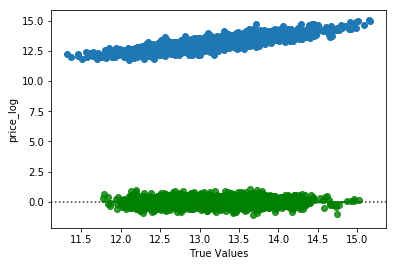

In [144]:
KC.predict_test()

### Build a Polynomial Version